Using the CNN in InceptionV3 to make image more fantastic

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

## Download the image(from wikipedia)

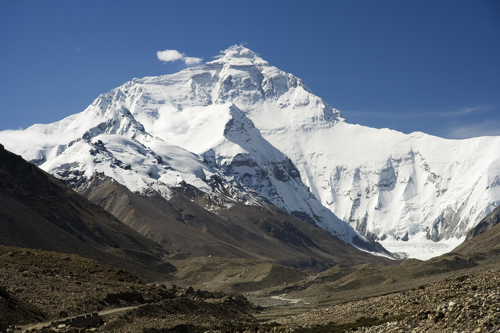

In [2]:
import IPython.display as display
import PIL.Image

import requests
url = "https://upload.wikimedia.org/wikipedia/commons/e/e7/Everest_North_Face_toward_Base_Camp_Tibet_Luca_Galuzzi_2006.jpg"
img_path = "mountain.jpg"
req = requests.get(url, stream=True)
with open(img_path, "wb") as f:
  for chunk in req.iter_content():
    f.write(chunk)

img = PIL.Image.open(img_path)
img = img.resize((500,333))
img

## Import pretained model and parameter

In [3]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


## Maximize mixed7 layer activity

In [19]:
# Maximize the activations of these layers
names = ['mixed7']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

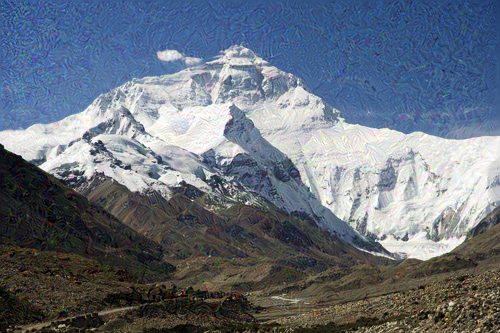

In [20]:
step = 50
step_size=0.01

def cal_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)
def deep_dream(img, step, step_size):
  img_np = np.array(img)
  img_np = tf.keras.applications.inception_v3.preprocess_input(img_np)
  img_np = tf.convert_to_tensor(img_np)
  for i in range(step):
    with tf.GradientTape() as tape:
      tape.watch(img_np)
      loss = cal_loss(img_np, dream_model)
    gradients = tape.gradient(loss, img_np)
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    img_np = img_np + gradients*step_size
    img_np = tf.clip_by_value(img_np, -1, 1)

  result = deprocess(img_np.numpy())
  return PIL.Image.fromarray(np.array(result))

deep_dream(img, step, step_size)

## Improve with octave

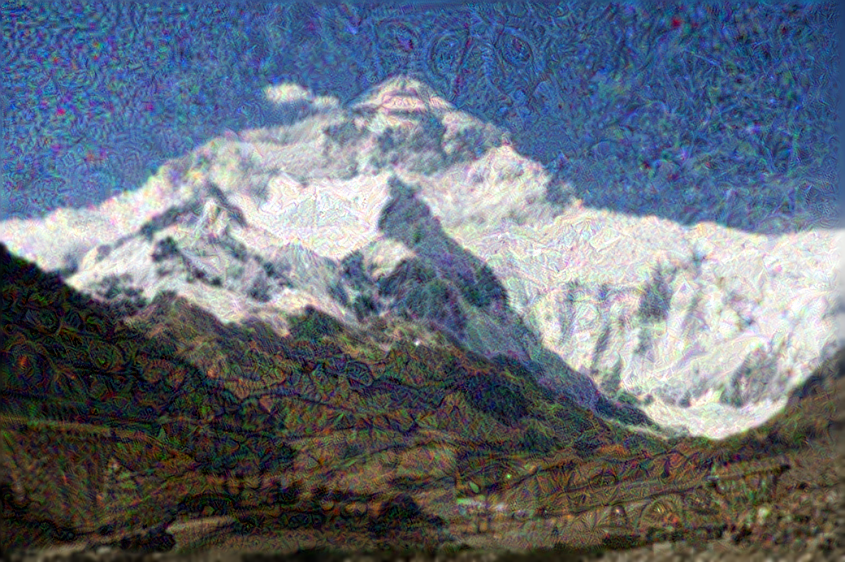

In [21]:
OCTAVE_SCALE = 1.30
img_tf = tf.constant(np.array(img))
base_shape = tf.shape(img_tf)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)


for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img_tf = tf.image.resize(img_tf, new_shape).numpy()

  img_tf = deep_dream(img=img_tf, step=50, step_size=0.01)

img_tf